In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('NSE-TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


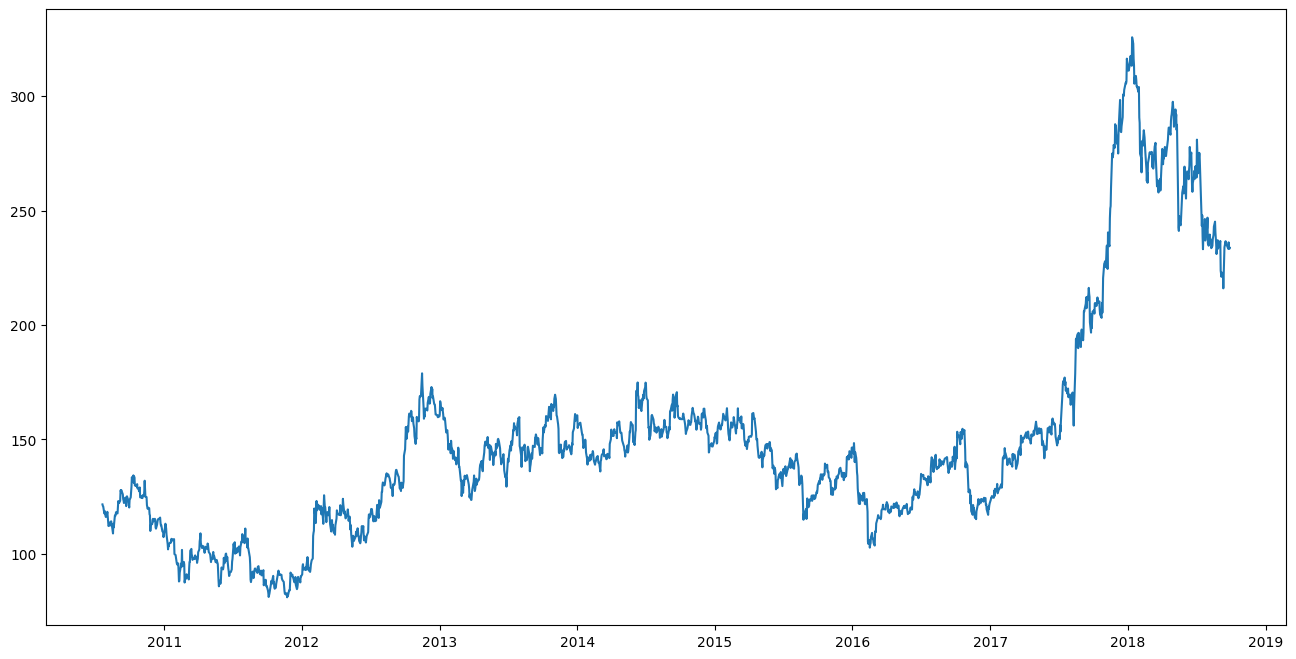

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.index = df['Date']

import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(df['Close'])

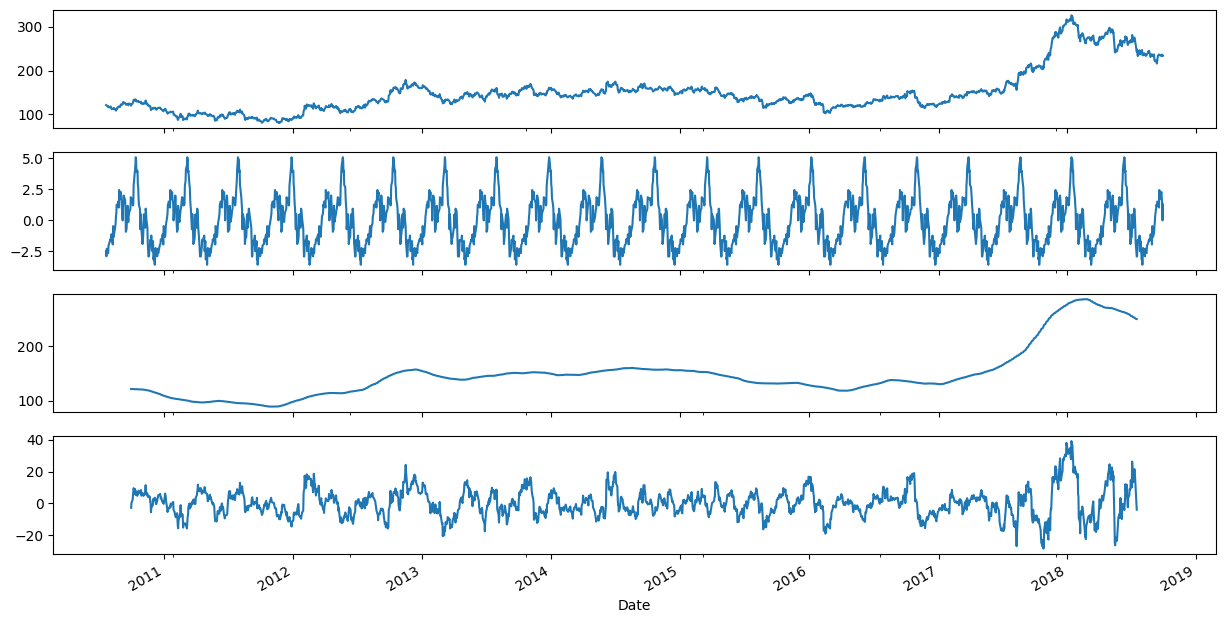

In [5]:
# pip install statsmodel
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df['Close'], model='additive', period=100)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,8), sharex=True)
resultado.observed.plot(ax=ax1)
resultado.seasonal.plot(ax=ax2)
resultado.trend.plot(ax=ax3)
resultado.resid.plot(ax=ax4)
plt.show()



In [6]:
df = df.sort_index(ascending=True, axis=0)
new_data = df[['Close', 'Date']].copy()
new_data.head()

new_data['Ano'] = new_data['Date'].dt.year
new_data['Mes'] = new_data['Date'].dt.month
new_data['Dia'] = new_data['Date'].dt.day

new_data.drop('Date', axis=1, inplace=True)

treino = new_data[:int(new_data.shape[0]*2/3)].copy()
teste = new_data[int(new_data.shape[0]*2/3):].copy()

X_train = treino.drop('Close', axis=1)
y_train = treino['Close']

X_teste = teste.drop('Close', axis=1)
y_teste = teste['Close']


from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [7]:
from sklearn.metrics import root_mean_squared_error
import numpy as np

y_pred = model.predict(X_teste)
root_mean_squared_error(y_teste, y_pred)

58.47039259728953

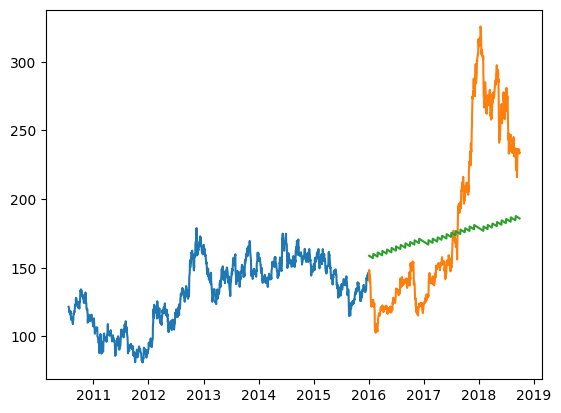

In [8]:
teste['Predictions'] = 0
teste['Predictions'] = y_pred

treino.index = new_data[:int(new_data.shape[0]*2/3)].index
teste.index = new_data[int(new_data.shape[0]*2/3):].index

plt.plot(treino['Close'])
plt.plot(teste[['Close', 'Predictions']])

In [9]:
janela = 5
def criar_janela(dados, tam_janela):
    X = []
    y = []
    for i in range(tam_janela, len(dados)):
        janela = dados.iloc[i-tam_janela:i]
        next_close = dados.iloc[i]['Close']

        caracteristicas = {
            'media_close': janela['Close'].mean()
        }
        X.append(caracteristicas)
        y.append(next_close)

    return pd.DataFrame(X), np.array(y)

X_train, y_train = criar_janela(treino, janela)
X_teste, y_teste = criar_janela(teste, janela)



from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [10]:
from sklearn.metrics import root_mean_squared_error
import numpy as np

y_pred = model.predict(X_teste)
root_mean_squared_error(y_teste, y_pred)

6.289339875087206

In [11]:
len(y_pred)

674

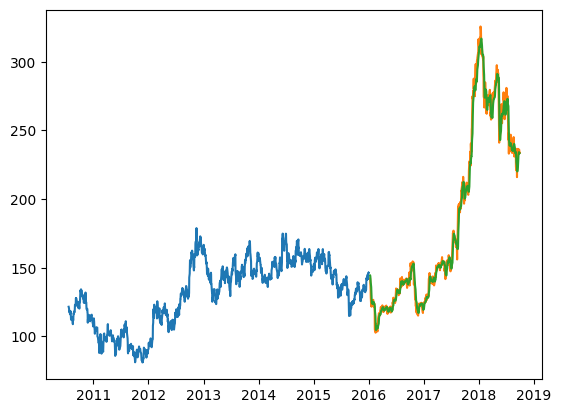

In [12]:
teste['Predictions'] = 0
teste2 = teste.iloc[5:].copy()
teste2['Predictions'] = y_pred

plt.plot(treino['Close'])
plt.plot(teste2[['Close', 'Predictions']])

In [37]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler
janela=5
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(treino[['Close']])

X_train, y_train = [], []
for i in range(janela, len(scaled_data)):
    X_train.append(scaled_data[i-janela:i, 0])
    y_train.append(scaled_data[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1351/1351 - 3s - loss: 0.0045 - 3s/epoch - 2ms/step
Epoch 2/10
1351/1351 - 2s - loss: 0.0026 - 2s/epoch - 2ms/step
Epoch 3/10
1351/1351 - 2s - loss: 0.0019 - 2s/epoch - 2ms/step
Epoch 4/10
1351/1351 - 2s - loss: 0.0014 - 2s/epoch - 1ms/step
Epoch 5/10
1351/1351 - 2s - loss: 0.0012 - 2s/epoch - 2ms/step
Epoch 6/10
1351/1351 - 2s - loss: 0.0011 - 2s/epoch - 2ms/step
Epoch 7/10
1351/1351 - 2s - loss: 0.0011 - 2s/epoch - 2ms/step
Epoch 8/10
1351/1351 - 2s - loss: 0.0010 - 2s/epoch - 2ms/step
Epoch 9/10
1351/1351 - 2s - loss: 9.6746e-04 - 2s/epoch - 1ms/step
Epoch 10/10
1351/1351 - 2s - loss: 0.0010 - 2s/epoch - 1ms/step


In [38]:
inputs = scaler.transform(teste[['Close']])

X_teste = []
for i in range(janela, inputs.shape[0]):
    X_teste.append(inputs[i-janela:i,0])
X_teste = np.array(X_teste)

X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

y_pred = model.predict(X_teste)
y_pred = scaler.inverse_transform(y_pred)

22/22 [==============================] - 1s 1ms/step


In [39]:
root_mean_squared_error(y_teste, y_pred)

14.692606191987025

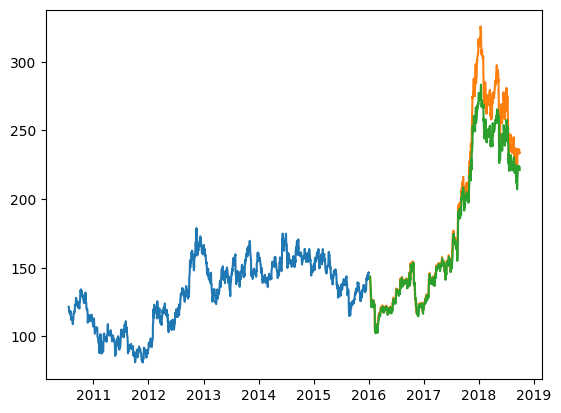

In [40]:
teste['Predictions'] = 0
teste2 = teste.iloc[5:].copy()
teste2['Predictions'] = y_pred

plt.plot(treino['Close'])
plt.plot(teste2[['Close', 'Predictions']])